First, we do this to avoid some errors when using Colab. 

In [1]:
!pip install "torch==1.4" "torchvision==0.5.0"

Second, we should update packages:

In [2]:
!curl https://course.fast.ai/setup/colab | bash
from fastai.vision import *

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   322  100   322    0     0   5649      0 --:--:-- --:--:-- --:--:--  5649
Updating fastai...
Done.


## Now we run some Javascript code in the browser and save the URLs of all the images we want for our dataset.

In Google Chrome press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>j</kbd> on Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>j</kbd> on macOS, and a small window the javascript 'Console' will appear. In Firefox press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>k</kbd> on Windows/Linux or <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>k</kbd> on macOS. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. Then you can run the following commands:

```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

## Create directory and upload urls file into our server

Choose an appropriate name for your labeled images.

In [9]:
folder = 'scolopendra'
file = 'urls_scolopendra.csv'

In [13]:
folder = 'scutigera_coleoptrata'
file = 'urls_scutigera_coleoptrata.csv'

In [14]:
path = Path('data/scoscu')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [8]:
path.ls()

[PosixPath('data/scoscu/scutigera_coleoptrata'),
 PosixPath('data/scoscu/scolopendra')]

### Finally, upload urls files in the working directory.

## Now you will need to download your images from their respective urls.

fast.ai has a function that allows you to do just that. You just have to specify the urls filename as well as the destination folder and this function will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

Let's download our images! Notice you can choose a maximum number of images to be downloaded. In this case we will not download all the urls.

You will need to run this line once for every category.


In [11]:
classes = ['scolopendra','scutigera_coleoptrata']

In [15]:
download_images(path/file, dest, max_pics=200, max_workers=0)

Remove any images that can't be opened:

In [16]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

scolopendra


scutigera_coleoptrata


## View data

In [17]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
# If already cleaned the data, run this cell instead of the one before
np.random.seed(42)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Now take a look at some of the pictures.

In [18]:
data.classes

['scolopendra', 'scutigera_coleoptrata']

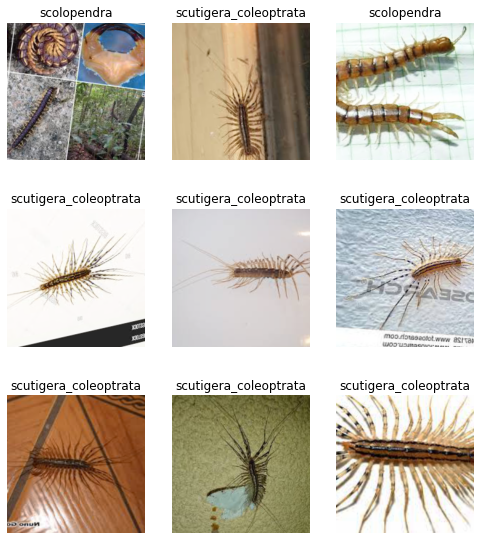

In [19]:
data.show_batch(rows=3, figsize=(7,8))

In [20]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['scolopendra', 'scutigera_coleoptrata'], 2, 320, 80)

## Now train the model.

In [21]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4)
learn.save('stage-1')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.030661,0.328035,0.150000,00:04
1,0.640066,0.351294,0.062500,00:03
2,0.460089,0.407609,0.050000,00:03
3,0.358738,0.438822,0.062500,00:03


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,time
0,0.102325,0.494069,0.062500,00:04
1,0.094479,0.453285,0.062500,00:04


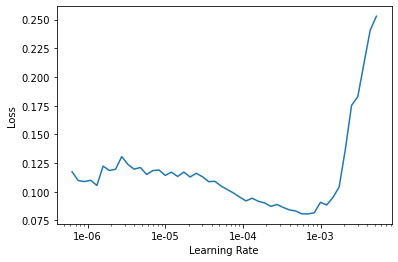

In [22]:
learn.unfreeze()
learn.lr_find()
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))
learn.save('stage-2')

## Interpretation

In [ ]:
learn.load('stage-1');

In [23]:
learn.load('stage-2');

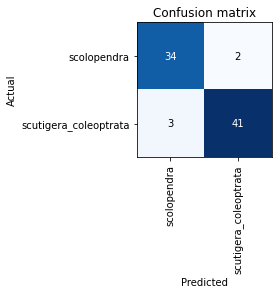

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Cleaning up the data.
There could be some images in our data set that shouldn't be.
Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

In [25]:
from fastai.widgets import *

First we need to get the file paths from our top_losses. We can do this with `.from_toplosses`. We then feed the top losses indexes and corresponding dataset to `ImageCleaner`.

Notice that the widget will not delete images directly from disk but it will create a new csv file `cleaned.csv` from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

In order to clean the entire set of images, we need to create a new dataset without the split. See [the thread](https://forums.fast.ai/t/duplicate-widget/30975/10) for more details.

In [26]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [ ]:
# If you already cleaned your data using indexes from `from_toplosses`,
# run this cell instead of the one before to proceed with removing duplicates.
# Otherwise all the results of the previous step would be overwritten by
# the new run of `ImageCleaner`.

db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                   .split_none()
                   .label_from_df()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

Then we create a new learner to use our new databunch with all the images.

In [27]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

In [28]:
learn_cln.load('stage-2');

In [ ]:
learn_cln.load('stage-1');

In [29]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [30]:
# Don't run this in google colab or any other instances running jupyter lab.
# If you do run this on Jupyter Lab, you need to restart your runtime and
# runtime state including all local variables will be lost.
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. `ImageCleaner` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses.ImageCleaner(ds, idxs)`

You can also find duplicates in your dataset and delete them! To do this, you need to run `.from_similars` to get the potential duplicates' ids and then run `ImageCleaner` with `duplicates=True`. The API works in a similar way as with misclassified images: just choose the ones you want to delete and click 'Next Batch' until there are no more images left.

Make sure to recreate the databunch and `learn_cln` from the `cleaned.csv` file. Otherwise the file would be overwritten from scratch, losing all the results from cleaning the data from toplosses.

In [31]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [32]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Remember to recreate your ImageDataBunch from your `cleaned.csv` to include the changes you made in your data!

## Putting the model in production

First thing first, let's export the content of our Learner object for production:

In [33]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [ ]:
defaults.device = torch.device('cpu')

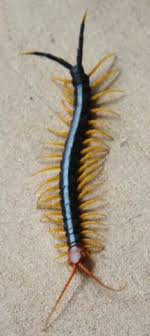

In [38]:
img = open_image(path/'scolopendra'/'00000124.jpg')
img

We create our `Learner` in production enviromnent like this, just make sure that `path` contains the file 'export.pkl' from before.

In [39]:
learn = load_learner(path)

In [40]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class.obj

'scolopendra'